In [337]:
# ensure latest module is used
from importlib import reload
import project_functions
reload(project_functions)

# import relevant libraries
import pandas as pd
import os
from project_functions import get_lap, plot_traj_reward, plot_misalignment, interpolate_trajectories, print_huber_losses

# PD Control Training Data

In [338]:
foldername = "test_data"

# get pd data
filepath_pd = os.path.join(foldername, 'test_pd_data.csv')
df_pd = pd.read_csv(filepath_pd)

x_pd = df_pd['cur_pos_x'].values
y_pd = df_pd['cur_pos_z'].values
ytrue = df_pd['steering_angle']

x_pd_lap, y_pd_lap = get_lap(x_pd, y_pd, 0.03, 0.03)
reward_pd_lap = df_pd['reward'].values[-len(x_pd_lap):]
neg_reward_pd = len([x for x in reward_pd_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_pd}")

# get ground truth data
filepath_gt = os.path.join(foldername, 'gt_udem1.csv')
df_gt = pd.read_csv(filepath_gt)

x_gt = df_gt['bez_x'].values
y_gt = df_gt['bez_z'].values

x_gt_lap, y_gt_lap = get_lap(x_gt, y_gt, 0.03, 0.03)

Negative Reward Count: 1923


## Raw Data - Base Model

Negative Reward Count: 1986
Model Test Huber Loss: 0.06744538148789722
PD and Model Huber Loss: 0.015321523122426945
Ground Truth and Model Huber Loss: 0.018696581489606404


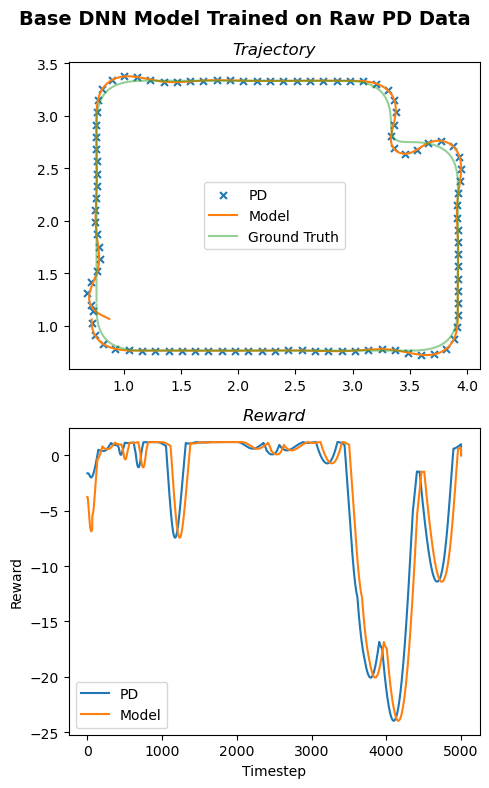

/Users/sophiachiang/Documents/ELEN90088/elen90088_final/project/project_functions.py:160: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


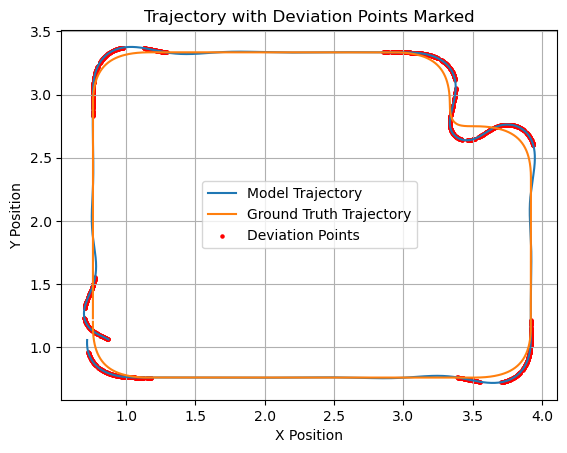

Time Spent Misaligned: 1704


In [346]:
model_name = "base_dnn_model_raw_pd"

# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.7, 0.005)
reward_model_lap = df_model['reward'].values[-len(x_model_lap):]
neg_reward_model = len([x for x in reward_model_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_model}")

# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)

plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Base DNN Model Trained on Raw PD Data")
plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)

## Raw Data - Regularised Model

Negative Reward Count: 2025
Model Test Huber Loss: 0.1162657110646906
PD and Model Huber Loss: 0.05062933271468079
Ground Truth and Model Huber Loss: 0.043192394894605586


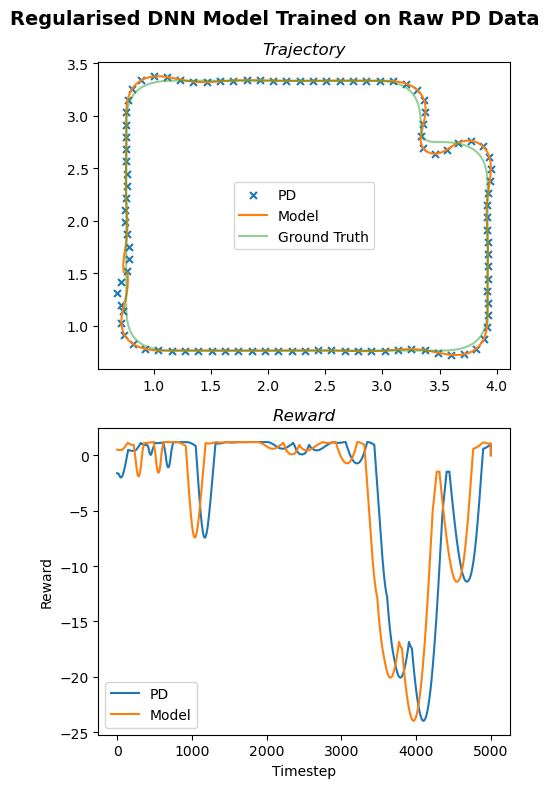

/Users/sophiachiang/Documents/ELEN90088/elen90088_final/project/project_functions.py:160: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


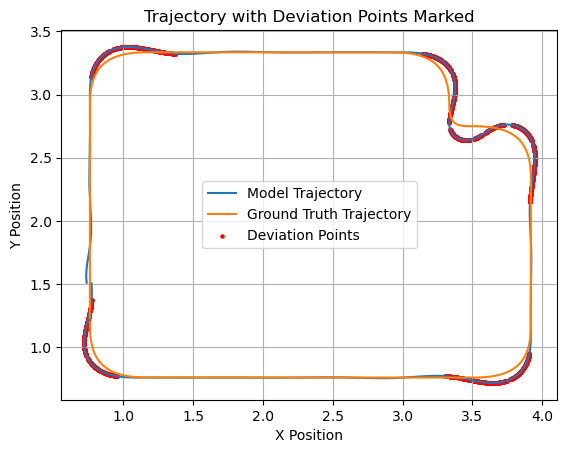

Time Spent Misaligned: 1590


In [340]:
model_name = "reg_dnn_model_raw_pd"

# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.7, 0.005)
reward_model_lap = df_model['reward'].values[-len(x_model_lap):]
neg_reward_model = len([x for x in reward_model_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_model}")

# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Regularised DNN Model Trained on Raw PD Data")
plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)

## Raw Data - Best Model

Negative Reward Count: 2004
Model Test Huber Loss: 0.06661432612741439
PD and Model Huber Loss: 0.016078238843027278
Ground Truth and Model Huber Loss: 0.012348533675923876


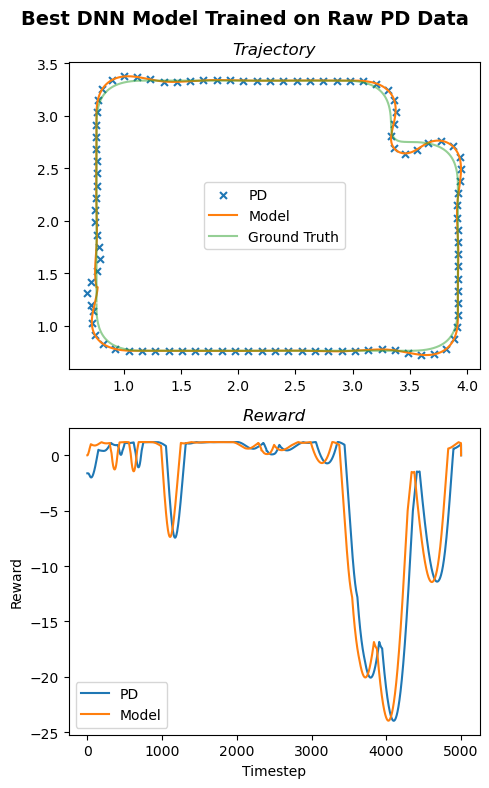

/Users/sophiachiang/Documents/ELEN90088/elen90088_final/project/project_functions.py:160: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


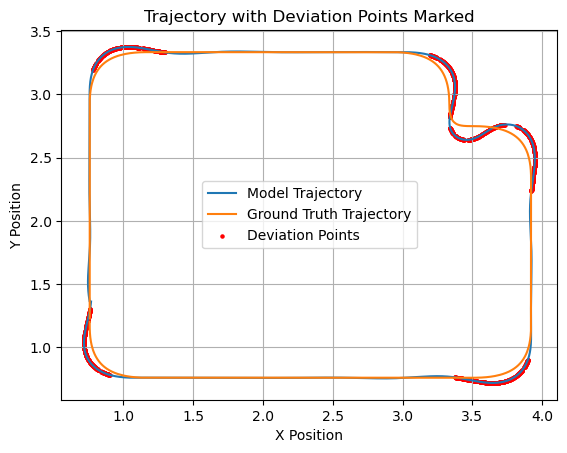

Time Spent Misaligned: 1355


In [341]:
model_name = "best_dnn_model_raw_pd"

# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.7, 0.005)
reward_model_lap = df_model['reward'].values[-len(x_model_lap):]
neg_reward_model = len([x for x in reward_model_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_model}")

# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Best DNN Model Trained on Raw PD Data")
plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)


## Processed Data - Base Model

Negative Reward Count: 2820
Model Test Huber Loss: 0.10635156030472909
PD and Model Huber Loss: 1.8593023056242461
Ground Truth and Model Huber Loss: 1.8464655935976795


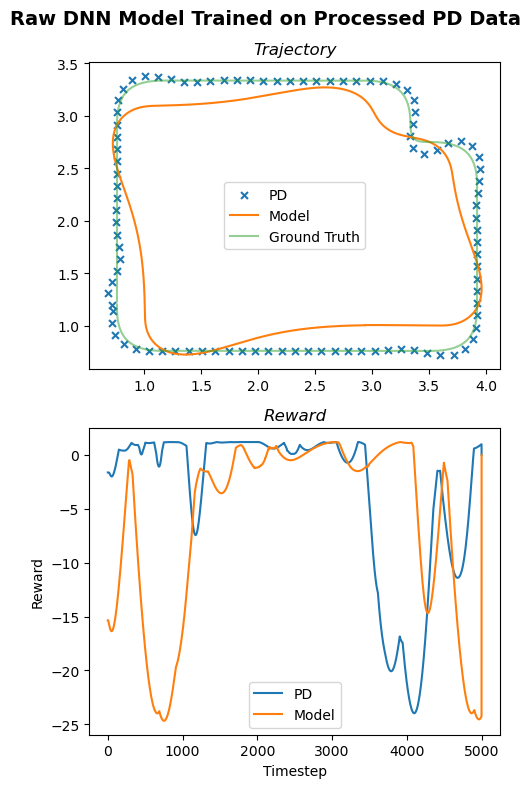

/Users/sophiachiang/Documents/ELEN90088/elen90088_final/project/project_functions.py:160: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


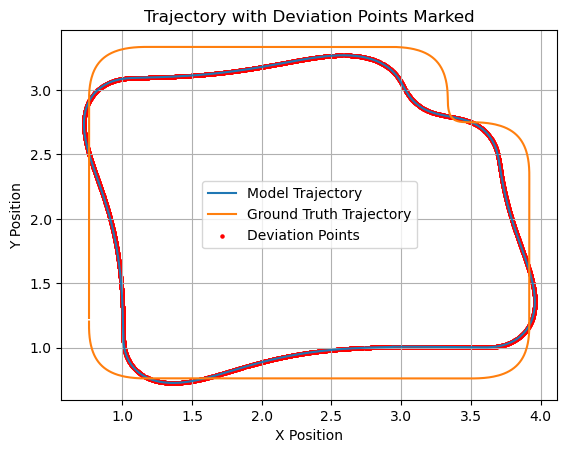

Time Spent Misaligned: 4160


In [342]:
model_name = "base_dnn_model_processed_pd"

# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.005, 0.005)
reward_model_lap = df_model['reward'].values[-len(x_model_lap):]
neg_reward_model = len([x for x in reward_model_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_model}")

# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Raw DNN Model Trained on Processed PD Data")
plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)


## Processed Data - Regularised Model

Negative Reward Count: 2846
Model Test Huber Loss: 0.15130474487252946
PD and Model Huber Loss: 1.7959898562565935
Ground Truth and Model Huber Loss: 1.7834998089668488


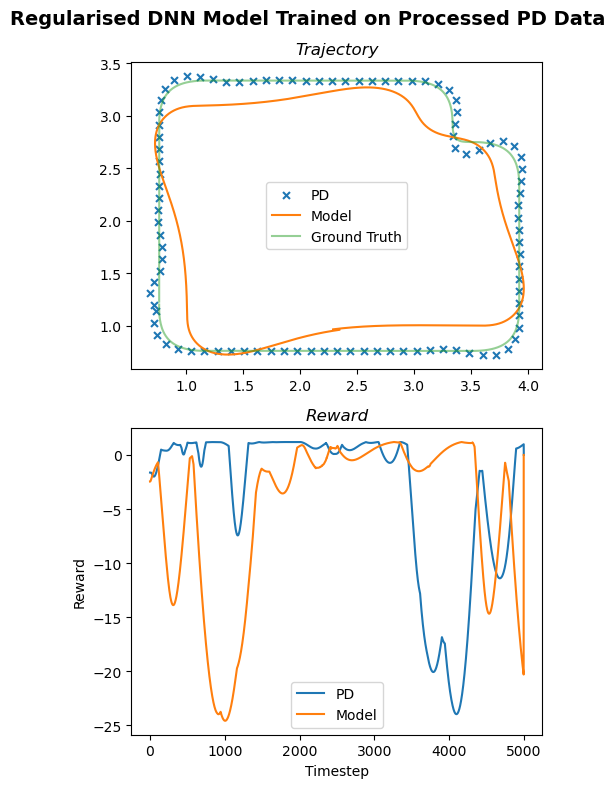

/Users/sophiachiang/Documents/ELEN90088/elen90088_final/project/project_functions.py:160: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


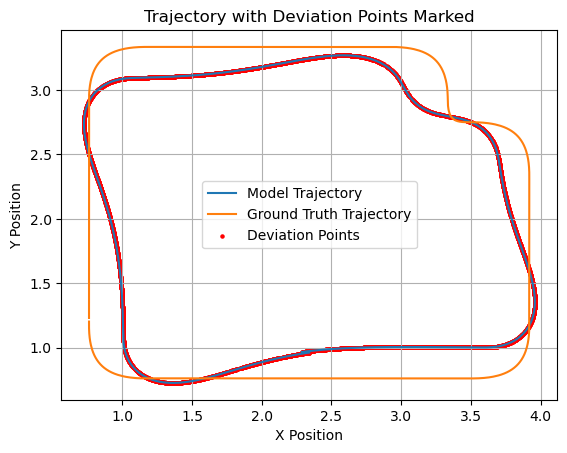

Time Spent Misaligned: 4172


In [343]:
model_name = "reg_dnn_model_processed_pd"

# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.7, 0.005)
reward_model_lap = df_model['reward'].values[-len(x_model_lap):]
neg_reward_model = len([x for x in reward_model_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_model}")

# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Regularised DNN Model Trained on Processed PD Data")
plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)

## Processed Data - Best Model

Negative Reward Count: 2826
Model Test Huber Loss: 0.10330397506613623
PD and Model Huber Loss: 1.851626736280428
Ground Truth and Model Huber Loss: 1.8388536010774537


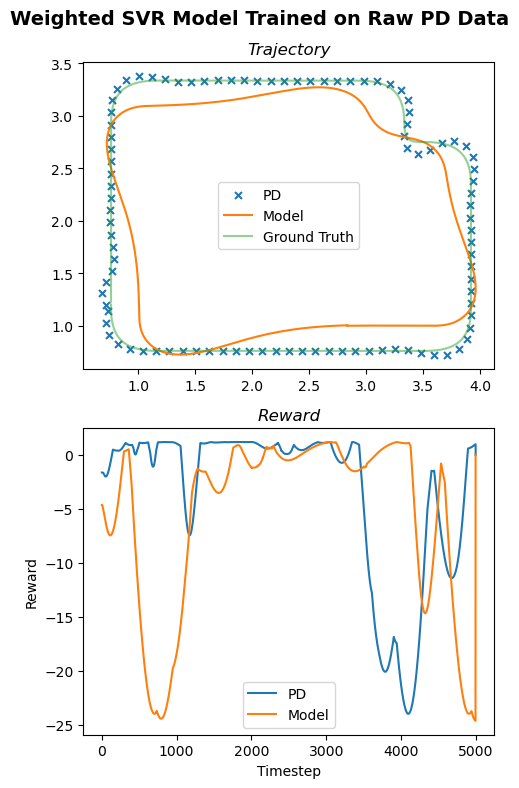

/Users/sophiachiang/Documents/ELEN90088/elen90088_final/project/project_functions.py:160: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


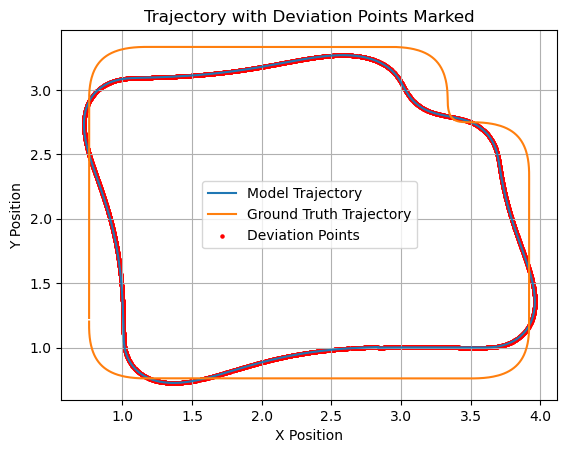

Time Spent Misaligned: 4161


In [344]:
model_name = "best_dnn_model_processed_pd"

# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.005, 0.005)
reward_model_lap = df_model['reward'].values[-len(x_model_lap):]
neg_reward_model = len([x for x in reward_model_lap if x < 0])
print(f"Negative Reward Count: {neg_reward_model}")

# evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Weighted SVR Model Trained on Raw PD Data")
plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)